# Outlier Detection 
(anomaly detection, noise detection, deviation detection, or exception mining)

## Definition Outlier
- An outlying observation, or outlier, is one that appears to deviate markedly from other members of the sample in which it occurs. (Grubbs, 1969)

- An observation which appears to be inconsistent with the remainder of that set of data. (Barnett and Lewis, 1994)

## Objective 
... to learn what "normal" data look like, and then use this view to detect abnormal instances or new trends in time series.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
sns.set()

In [3]:
tesla = pd.read_csv('../dataset/TSLA.csv')
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-23,62.250000,62.250000,60.090000,60.307999,60.307999,33274500
1,2018-03-26,61.467999,61.518002,58.271999,60.835999,60.835999,41876000
2,2018-03-27,60.799999,60.854000,55.436001,55.835999,55.835999,69360000
3,2018-03-28,52.916000,53.736000,50.419998,51.556000,51.556000,105007000
4,2018-03-29,51.298000,54.192001,49.641998,53.226002,53.226002,75853500


In [4]:
tesla.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
645,2020-10-14,449.779999,465.899994,447.350006,461.299988,461.299988,48045400
646,2020-10-15,450.309998,456.570007,442.500000,448.880005,448.880005,35672400
647,2020-10-16,454.440002,455.950012,438.850006,439.670013,439.670013,32775900
648,2020-10-19,446.239990,447.000000,428.869995,430.829987,430.829987,36287800
649,2020-10-20,431.750000,431.750000,419.049988,421.940002,421.940002,31656300


Now we will plot the histogram and check the distribution of the Close Price.

A histogram divides the values within a numerical variable into “bins”, and counts the number of observations that fall into each bin. By visualizing these binned counts in a columnar fashion, we can obtain a very immediate and intuitive sense of the distribution of values within a variable.


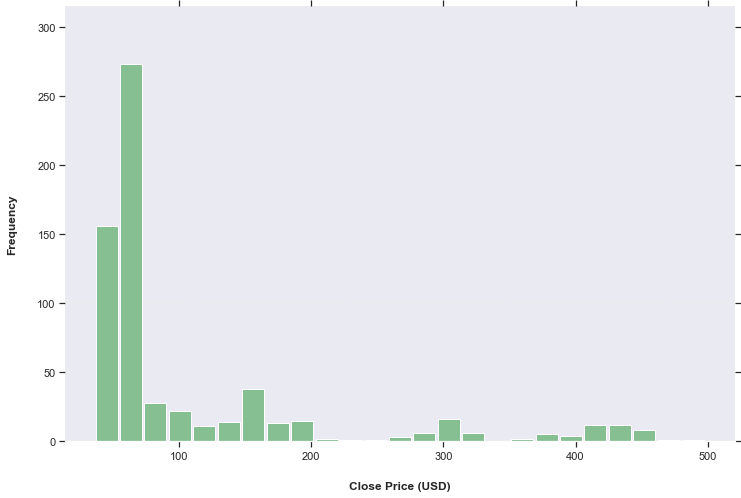

In [5]:
#axs = df_crosscorrelated[['Close', 'ma7', 'ma14', 'ma25']].hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = tesla.hist(column='Close',bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Close Price (USD)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

From the above graph, we can see that data is not centred towards the mean. The value going towards the left to the mean is decreasing whereas it is increasing towards the right. 

Let us see the descriptive statistics of this column like mean, standard deviation, min, and maximum values. Use the below code for the same. 

In [6]:
tesla['Close'].describe()

count    650.000000
mean     111.777840
std      104.646402
min       35.793999
25%       54.844501
50%       64.299000
75%      120.249498
max      498.320007
Name: Close, dtype: float64

Now we will use 3 standard deviations and everything lying away from this will be treated as an outlier. We will see an upper limit and lower limit using 3 standard deviations. Every data point that lies beyond the upper limit and lower limit will be an outlier. Use the below code for the same. 

In [7]:
upper = tesla['Close'].mean() + 3*tesla['Close'].std()
lower = tesla['Close'].mean() - 3*tesla['Close'].std()
print('upper bound: {}'.format(upper))
print('lower bound: {}'.format(lower))

upper bound: 425.71704506216366
lower bound: -202.1613654437021


In [8]:
print('{} of {} datapointa are outside 3 standard deviations.'.format(
    tesla['Close'].shape[0]-tesla[(tesla['Close']<upper) & (tesla['Close']>lower)].shape[0],
    tesla['Close'].shape[0]))

20 of 650 datapointa are outside 3 standard deviations.


## Z-score

Simple, we can use Z-score to detect outliers, which timestamps gave very uncertain high and low value. (to define outliers for a single numeric variable)

It tells us about how far data is away from standard deviation. It is calculated by subtracting the mean from the data point and dividing it by the standard deviation.  

The Z-score formula for a sample would be as follows:

$$z=\frac{x-\mu}{\sigma}$$

where:
- $x$ = score,
- $\mu$ = mean of the population,
- $\sigma$ = Population Standard deviation

Let us see practically how this is done. 

In [9]:
zscore_close = (tesla['Close'] - tesla['Close'].mean()) / tesla['Close'].std()

We can see for each row the z score is computed. 

Now we will detect only those rows that have z score greater than 3 or less than -3. 

Use the function below. 

In [10]:
def detect(signal, treshold = 3.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

Based on z-score table, 3.0 already positioned at 99.73% of the population.
![alt text](https://ai-ml-analytics.com/wp-content/uploads/2020/06/image-41.png "residuals vs z-score")
https://ai-ml-analytics.com/z-scores-in-statistics/

In [11]:
outliers = detect(zscore_close)
print (print('{} of {} datapointa are outside 3 standard deviations.'.format(
    np.array(outliers).shape[0],
    tesla['Close'].shape[0])))

20 of 650 datapointa are outside 3 standard deviations.
None


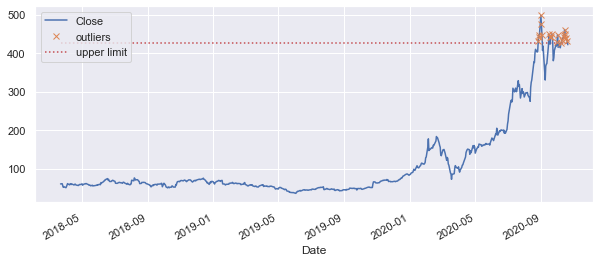

In [12]:
fig, ax = plt.subplots(figsize=(10,4))
tesla.plot(x='Date',y='Close',ax=ax)
ax.plot(tesla['Date'], tesla['Close'], 'x', markevery=outliers, label="outliers")
ax.hlines(upper, tesla['Date'].min(), tesla['Date'].max(), colors='r', linestyles='dotted', label='upper limit')
plt.legend()
plt.show()

We can see that, we have outliers but not very usefull. 

## Lag Correlation and Moving Average

We can create features with lag and moving average to performa a [outliers detection in multivariate data](https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3). 

There are various distance metrics, scores, and techniques to detect outliers:

 - **Euclidean Distance (ED):** to identify outliers based on their distance to the center point
 - **Mahalanobis Distance (MD):** to identify outliers based on their scaled distance to the center point. It is scaled in such a way, that the principle component axis have unit variance. ([see also](https://en.wikipedia.org/wiki/Mahalanobis_distance))

In [13]:
def df_shift(df,lag=0, start=1, skip=1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(start,lag+1,skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=skip
        df = pd.concat([df, dfn], axis = 1).reindex(df.index)
    return df

In [14]:
tesla = tesla[['Date','Close']]
tesla.head(1)

,Date,Close
0,2018-03-23,60.307999


In [15]:
df_crosscorrelated = df_shift(tesla, lag = 10, start = 1, skip = 2,rejected_columns=['Date'])
df_crosscorrelated['ma7'] = df_crosscorrelated['Close'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['Close'].rolling(14).mean()
df_crosscorrelated['ma25'] = df_crosscorrelated['Close'].rolling(25).mean()
df_crosscorrelated.head(10)

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,ma7,ma14,ma25
0,2018-03-23,60.307999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-26,60.835999,60.307999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-27,55.835999,60.835999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-28,51.556000,55.835999,60.307999,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-29,53.226002,51.556000,60.835999,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-04-02,50.495998,53.226002,55.835999,60.307999,NaN,NaN,NaN,NaN,NaN
6,2018-04-03,53.506001,50.495998,51.556000,60.835999,NaN,NaN,55.109143,NaN,NaN
7,2018-04-04,57.388000,53.506001,53.226002,55.835999,60.307999,NaN,54.692000,NaN,NaN
8,2018-04-05,61.144001,57.388000,50.495998,51.556000,60.835999,NaN,54.736000,NaN,NaN
9,2018-04-06,59.860001,61.144001,53.506001,53.226002,55.835999,60.307999,55.310858,NaN,NaN


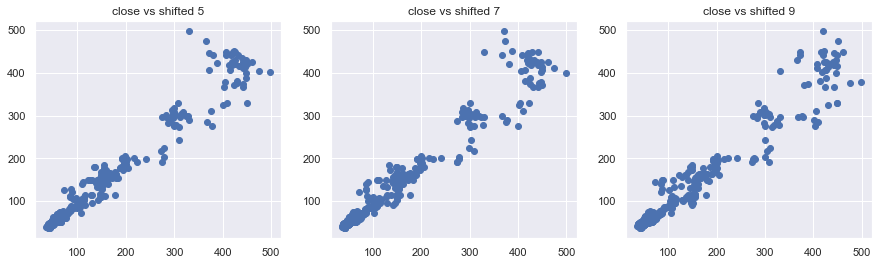

In [16]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'])
plt.title('close vs shifted 5')
plt.subplot(1,3,2)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'])
plt.title('close vs shifted 7')
plt.subplot(1,3,3)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'])
plt.title('close vs shifted 9')
plt.show()

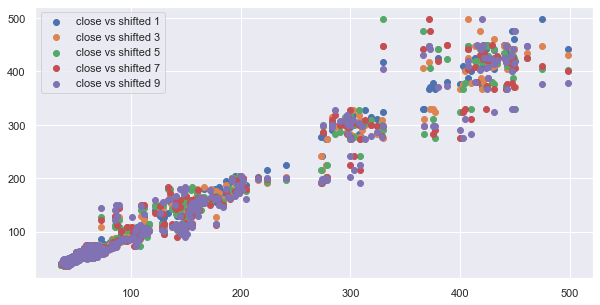

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_1'],label='close vs shifted 1')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_3'],label='close vs shifted 3')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'],label='close vs shifted 5')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'],label='close vs shifted 7')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'],label='close vs shifted 9')
plt.legend()
plt.show()

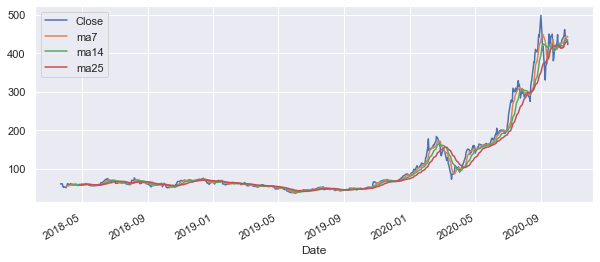

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated.plot(x='Date',y=['Close','ma7','ma14','ma25'],ax=ax)
plt.show()

### distance between center and point

- center point
- covariance matrix

In [19]:
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']
crosscorrelated = df_crosscorrelated[selected_column].dropna().to_numpy()
print ('degrees of freedom: {}'.format(crosscorrelated.shape[1]))

# Covariance matrix
covariance = np.cov(crosscorrelated , rowvar=False)

# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Center point
centerpoint = np.mean(crosscorrelated , axis=0)


degrees of freedom: 9


We are ready to find the distance between the center point and each observation (point) in the data-set. We also need to find a cutoff value from the Chi-Square distribution. The reason why Chi-Square is used to find cutoff value is, Mahalanobis Distance returns the distance as squared ($D^2$). We should also take the quantile value as 0.95 while finding cutoff because the points outside the 0.95 (two-tailed) will be considered as an outlier. Less quantile means less cutoff value. We also need a degree of freedom value for Chi-Square, and it is equal to the number of variables in our data-set, so 9.

In [20]:
from scipy.stats import chi2

# Distances between center point and 
distances = []
for i, val in enumerate(crosscorrelated):
      p1 = val
      p2 = centerpoint
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.95, crosscorrelated.shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff )

print('--- Index of Outliers ----')
print(outlierIndexes[0])

#print('--- Observations found as outlier -----')
#print(crosscorrelated[ distances > cutoff , :])

--- Index of Outliers ----
[446 448 450 451 452 454 468 469 471 473 474 475 476 477 478 479 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 573 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591
 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609
 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625]


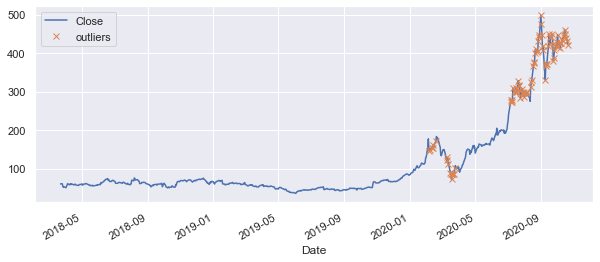

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
tesla.plot(x='Date',y='Close',ax=ax)
ax.plot(tesla['Date'], tesla['Close'], 'x', markevery=outlierIndexes[0]+df_crosscorrelated.shape[0]-crosscorrelated.shape[0], label="outliers")
plt.legend()
plt.show()

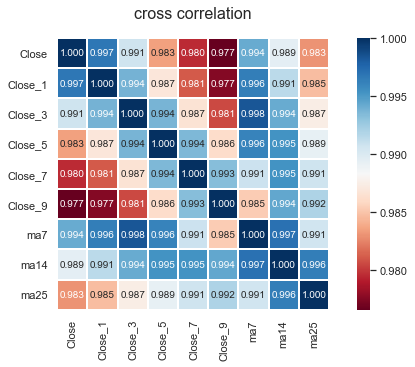

In [22]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 5))
ax=plt.subplot(111)
plt.title('cross correlation', y=1.05, size=16)
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']

sns.heatmap(df_crosscorrelated[selected_column].corr(), ax=ax, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, fmt='.3f', annot_kws={"fontsize":10})
plt.show()

## Clustering

Any instance that has low affinity to all the clusters is likely to be an outier.

### K-Mean

K-Mean is an algorithm that can cluster datasets with known number of clusters $k$ very efficiently. 

Lets train a K-Means cluster on the dataset from above and plot the score as a function of $k$:

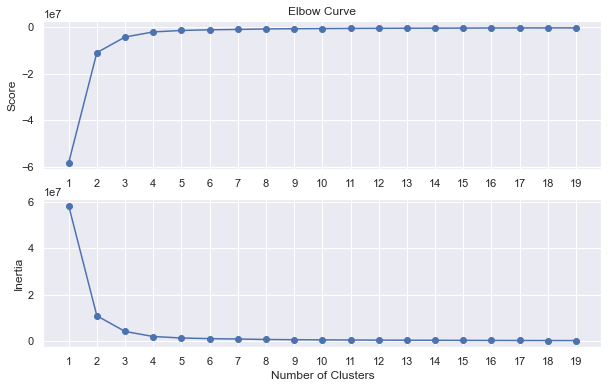

In [23]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
data = df_crosscorrelated.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
inertia = [kmeans[i].inertia_ for i in range(len(kmeans))]

fig, ax = plt.subplots(sharex="all",figsize=(10,6))
plt.subplot(2, 1, 1)
plt.plot(n_cluster, scores,'o-')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.xticks(n_cluster)
plt.subplot(2, 1, 2)
plt.plot(n_cluster, inertia,'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(n_cluster)
plt.show()

**Inertia**: Sum of squared distances of samples to their closest cluster center.

**Score**: Opposite of the value of X on the K-means objective.

We can see that after 4 Cluster we are not seeing any more variance so we can train model with 4 Cluster now

/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # This is added back by InteractiveShellApp.init_path()


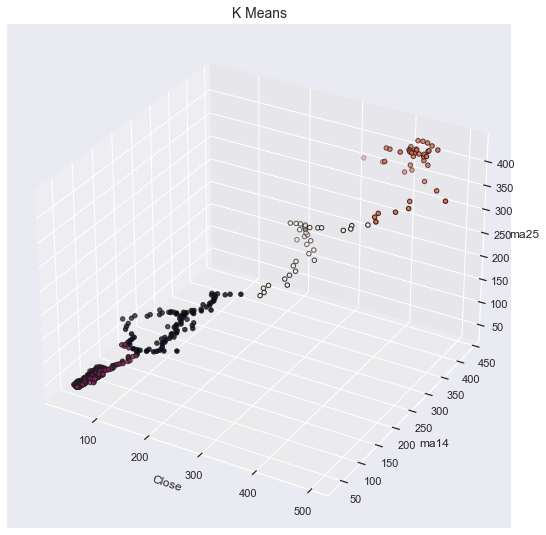

In [24]:
from mpl_toolkits.mplot3d import Axes3D

X = df_crosscorrelated[['Close','ma14','ma25']].dropna()
X = X.reset_index(drop=True)
km = KMeans(n_clusters=4)
km.fit(X)
km.predict(X)
labels = km.labels_

fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Close")
ax.set_ylabel("ma14")
ax.set_zlabel("ma25")
plt.title("K Means", fontsize=14)
plt.show()

from sklearn.decomposition import PCA

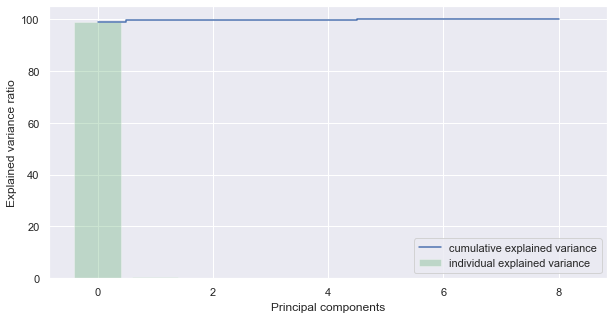

In [25]:
from sklearn.preprocessing import StandardScaler

X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

You can see that the first component contain 99% Explained variance

In [26]:
# Take useful feature and standardize them
X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data.tail()

,0,1
621,3.224317,0.691788
622,3.198471,-0.426672
623,3.220565,0.474296
624,3.216121,0.441537
625,3.206830,1.372481


In [27]:
df = df_crosscorrelated.dropna().copy()
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[3].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    525
2     42
1     37
3     22
Name: cluster, dtype: int64

In [28]:
df.head()

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,ma7,ma14,ma25,cluster,principal_feature1,principal_feature2
0,2018-04-27,58.816002,57.096001,56.692001,58.048000,58.669998,58.242001,57.640000,58.424286,57.60112,0,-0.522131,0.104555
1,2018-04-30,58.779999,58.816002,56.138000,56.674000,60.015999,57.537998,57.463429,58.270000,57.54000,0,-0.522182,0.078367
2,2018-05-01,59.984001,58.779999,57.096001,56.692001,58.048000,58.669998,57.740001,58.255572,57.50592,0,-0.520574,0.033291
3,2018-05-02,60.230000,59.984001,58.816002,56.138000,56.674000,60.015999,58.248001,58.356572,57.68168,0,-0.516937,-0.010474
4,2018-05-03,56.889999,60.230000,58.779999,57.096001,56.692001,58.048000,58.276286,58.129571,57.89504,0,-0.521345,0.011719


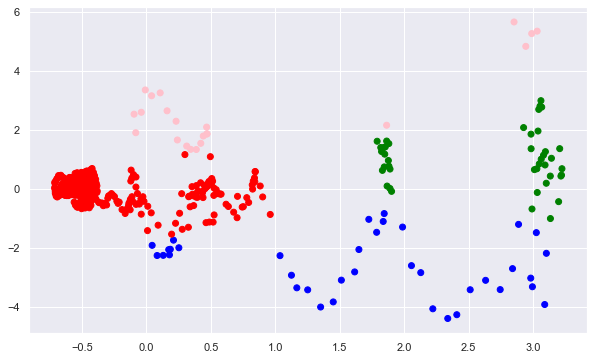

In [29]:
# plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show();

In [30]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series(dtype="float64")
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

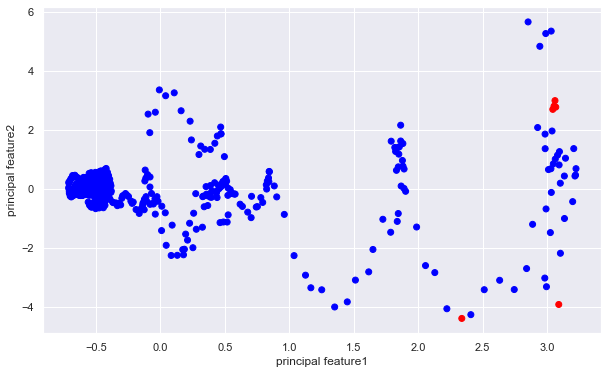

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

In [32]:
df.anomaly1.value_counts()

0    620
1      6
Name: anomaly1, dtype: int64

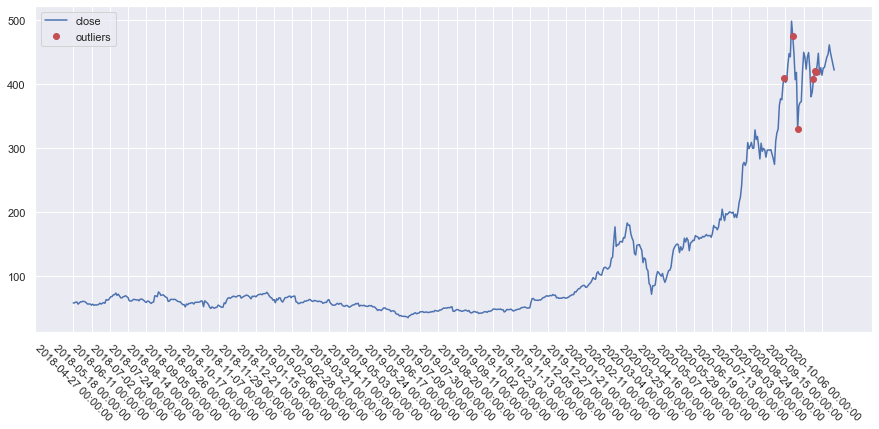

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='close',c='b')
plt.plot(df['Close'], 'o', label='outliers',markevery=df.loc[df['anomaly1'] == 1].index.tolist(),c='r')
plt.xticks(np.arange(df.shape[0])[::15],df['Date'][::15],rotation='-45')
plt.legend()
plt.show()

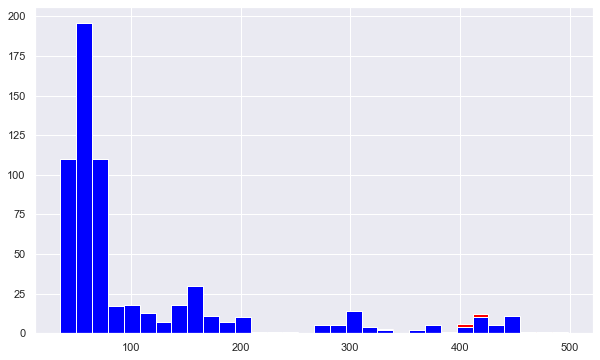

In [34]:
a = df.loc[df['anomaly1'] == 0, 'Close']
b = df.loc[df['anomaly1'] == 1, 'Close']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

In [35]:
ori_len = df_crosscorrelated.shape[0] - X.shape[0]
ori_len

24

In [36]:
#np.where(outliers==-1)[0] + ori_len

## IsolationForest

I will use IsolationForest from sklearn library. When defining the algorithm there is an important parameter called contamination. It is the percentage of observations that the algorithm will expect as outliers. We fit the X (2 features HP and Speed) to the algorithm and use fit_predict to use it also on X. This produces plain outliers (-1 is outlier, 1 is inlier). We can also use the function decision_function to get the scores Isolation Forest gave to each sample.

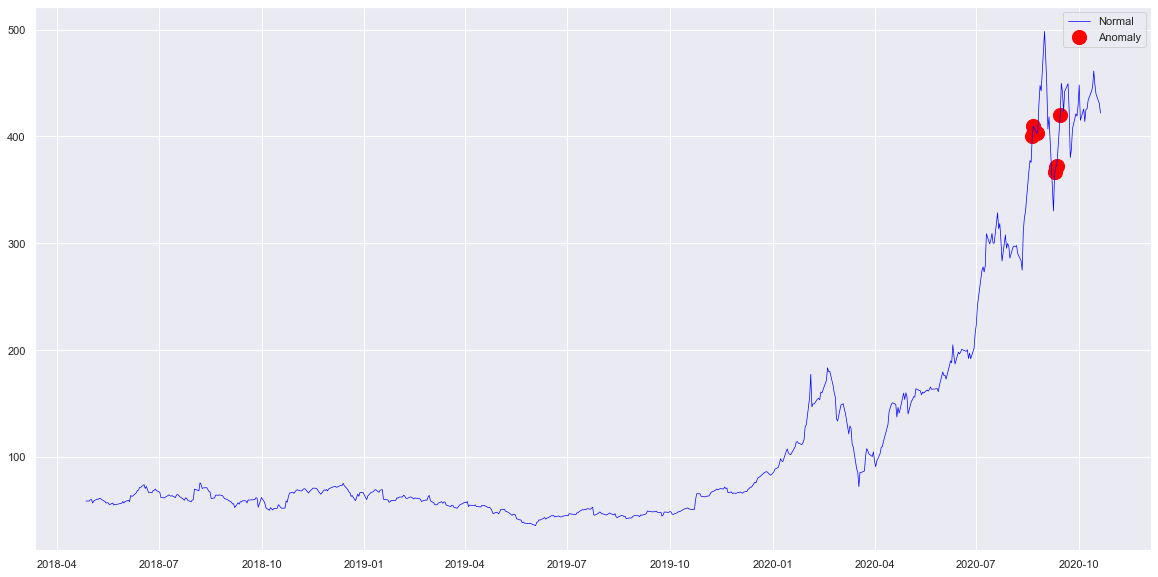

In [37]:
from sklearn.ensemble import IsolationForest

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
data = pd.DataFrame(np_scaled)

# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)
df['anomaly2'] = pd.Series(model.predict(np_scaled))

fig, ax = plt.subplots(figsize=(20,10))

a = df.loc[df['anomaly2'] == -1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label = 'Normal',linewidth=0.7)
ax.scatter(a['Date'],a['Close'], color='red', label = 'Anomaly', s = 200)
plt.legend()
plt.show();

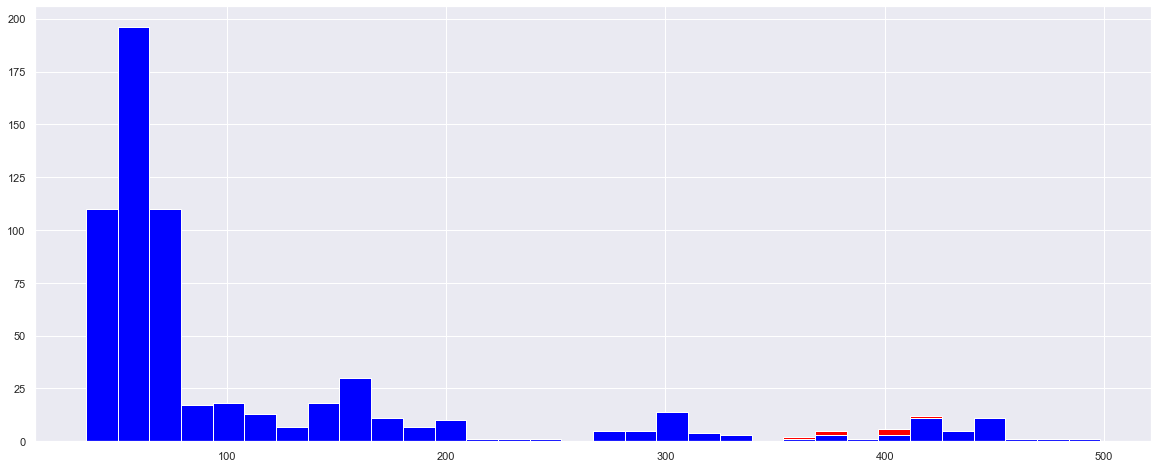

In [38]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'Close']
b = df.loc[df['anomaly2'] == -1, 'Close']

fig, axs = plt.subplots(figsize=(20,8))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

## Support Vector Machine (SVM)

A support vector machine is another effective technique for detecting anomalies. A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems.

### One class SVM

According to the paper: Support Vector Method for Novelty Detection. SVMs are max-margin methods, i.e. they do not model a probability distribution. The idea of SVM for anomaly detection is to **find a function that is positive for regions with high density of points, and negative for small densities**.

- Unsupervised Outlier Detection.
- Estimate the support of a high-dimensional distribution.
- The implementation is based on [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/).

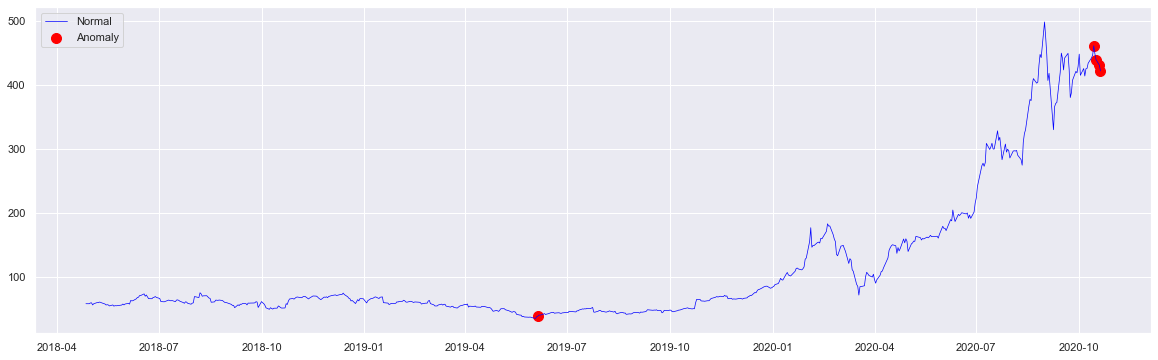

In [39]:
from sklearn.svm import OneClassSVM

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
data = pd.DataFrame(np_scaled)

# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)

df['anomaly3'] = pd.Series(model.predict(np_scaled))

fig, ax = plt.subplots(figsize=(20,6))

a = df.loc[df['anomaly3'] == -1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label ='Normal', linewidth = 0.7)
ax.scatter(a['Date'],a['Close'], color='red', label = 'Anomaly', s = 100)
plt.legend()
plt.show();

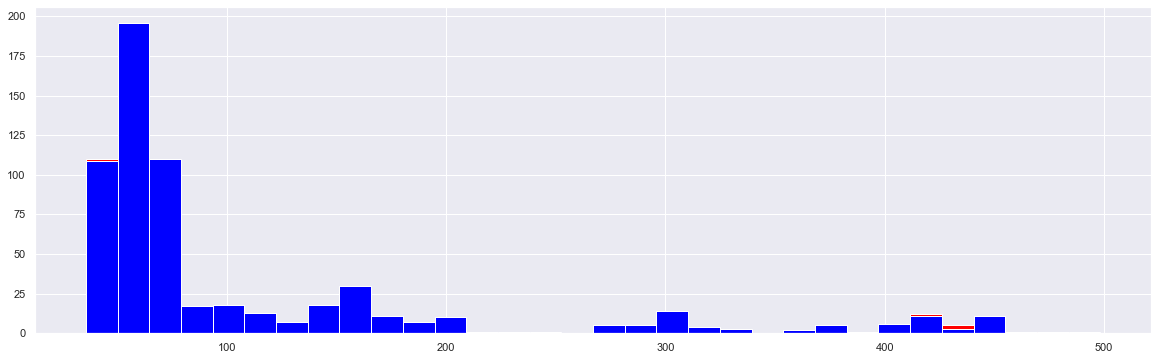

In [40]:
a = df.loc[df['anomaly3'] == 1, 'Close']
b = df.loc[df['anomaly3'] == -1, 'Close']

fig, axs = plt.subplots(figsize=(20,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

## Gaussian Distribution

We will be using the Gaussian distribution (normal distribution) to develop an anomaly detection algorithm, that is, we’ll assume that our data are normally distributed. This is an assumption that cannot hold true for all data sets, yet when it does, it proves an effective method for spotting outliers.

Scikit-Learn’s `covariance.EllipticEnvelope` is a function that tries to figure out the key parameters of our data’s general distribution by assuming that our entire data is an expression of an underlying multivariate Gaussian distribution.

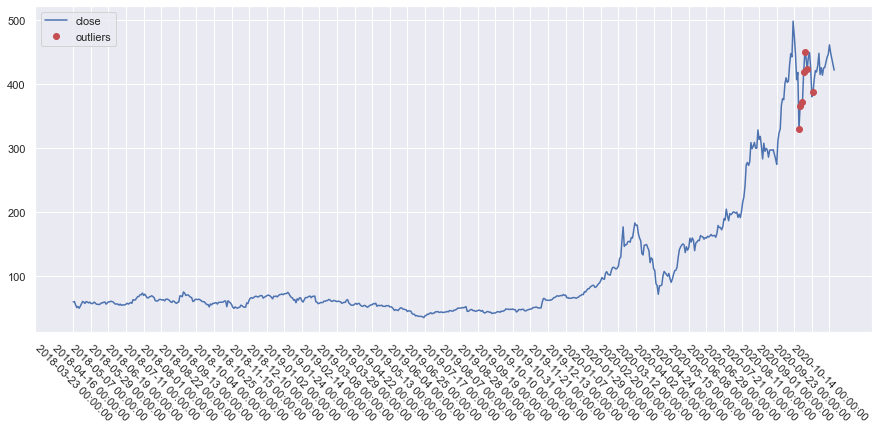

In [41]:
from sklearn.covariance import EllipticEnvelope

envelope = EllipticEnvelope(contamination = outliers_fraction)
X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
envelope.fit(np_scaled)
outliers = envelope.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

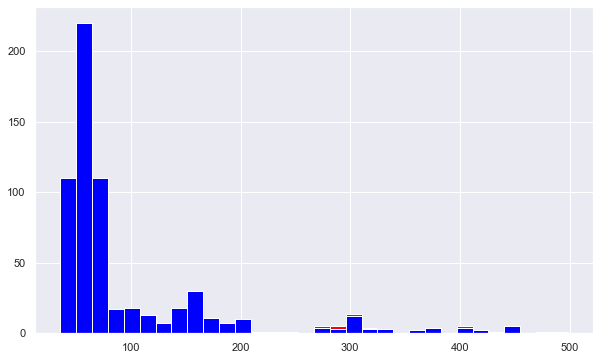

In [42]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()